## Description
### This Jupyter Notebook is used for training the classifiers based on descriptors values from training dataset.

#### Workflow:
1. The training dataset in the form of a .csv file is read into a dataframe, followed by generating a Pearson Correlation Table to identify collinearity within the set of descriptors. 
2. Descriptors which are highly collinear are removed.
3. The training data is then standardized. Two features with the highest Pearson Coefficient with the target variable are chosen for classifier training. With two features, we are able to visualize the classifier with a decision boundary on a 2D map.
4. Best hyperparameters are obtained for each type of classifiers.
5. Decision boundaries are created and visualized.
6. Further training is conducted by using charge of ligand as an additional descriptor.



In [1]:
#Import libraries
import re 
import os
import math
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib as mpl
import plotly.graph_objects as go
import plotly.io as pio

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, LeaveOneOut,train_test_split, GridSearchCV


In [2]:
def confMat(y, preds):
    mat = confusion_matrix(y, preds)
    sns.heatmap(
        mat.T, 
        square=True, 
        annot=True, 
        fmt='d', 
        cbar=False,
        xticklabels=nonalt_unique,
        yticklabels=nonalt_unique
    )
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

In [3]:
def GenerateMesh(data, trainedModel, descriptor_set, decisionFunction=True, dimValue="mean"):
    data=data.copy()
    meshes={}
    for i in data.drop(columns=["Nonalt","Name"]).columns:
        if i in data.columns:
            meshes.update({f"{i}": np.linspace(data[i].min(), data[i].max(), 10)})
#         print(i)
#         meshes.update({f"{i}": np.linspace(eval("data." + i + ".min()"), eval("data." + i + ".max()"), 10)})
    
    
    # set meshgrid with features
    descriptor_1, descriptor_2, descriptor_3 = np.meshgrid(
        meshes[descriptor_set[0]],
        meshes[descriptor_set[1]],
        meshes[descriptor_set[2]],
        indexing='ij'
    )

    sepalPetal = np.vstack([descriptor_1.ravel(), descriptor_2.ravel(), descriptor_3.ravel()]).T  
    if dimValue=="mean":
        sepalPetal[:,1] = sepalPetal[:,2].mean()
    elif dimValue==None:
        ;
    else:
        sepalPetal[:,1] = dimValue
        
    d = trainedModel.predict(sepalPetal)
    
    MeshDat = pd.DataFrame(sepalPetal, columns=data.drop(columns=["Nonalt","Name"]).columns)
    MeshDat["Nonalt"] = d
    
    data["OA"] = "original"
    MeshDat["OA"] = "artificial"

    IRISArt = pd.concat([data, MeshDat])
    return IRISArt.reset_index(drop=True)

In [4]:
def VisualizeBoundary(data, alpha=0.01, title="", squareSize=40):
    colors = {"Non-alternating": "blue", "Alternating": "orange", "Candidate":"grey", "Target":"red"}
    vizList = []
    for i in data["Nonalt"].unique():
        if i == "Candidate":
            continue
        for j in data.OA.unique():
            if j == "original":
                o = 1
                sh = "circle"
                si = 6
                txt = ""
            else:
                o = alpha
                sh = "square"
                si = squareSize
                txt = "boundary"

            globals()[f"D_{i}_{j}"]=go.Scatter3d(
                x=data.loc[(data["Nonalt"] == i) & (data.OA == j), descriptor_1],
                y=data.loc[(data["Nonalt"] == i) & (data.OA == j), descriptor_2],
                z=data.loc[(data["Nonalt"] == i) & (data.OA == j), descriptor_3],
                name=i + " " + txt,
                hovertemplate=descriptor_1+': %{x} <br>' + \
                    descriptor_2 +': %{y} <br>' + \
                    descriptor_3 +': %{z} <br>' + \
                    'Nonalt: {0} {1}'.format(i,j),
                mode='markers',
                marker=dict(
                    size=si,
                    color=colors[i],           
                    opacity=o,
                    symbol=sh
                )
            )

            vizList.append(globals()[f"D_{i}_{j}"]) 

    fig = go.Figure(data=vizList)
    
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1, y=-1.75, z=1.5)
    )

    fig.update_layout(
        scene_camera=camera,
        autosize=True,
        template="plotly_white",
        scene={
            "xaxis_title":r'NBO_diff_standardized',
            "yaxis_title":r'Overall_charge_standardized',
            "zaxis_title":r'%_Filled_y_standardized'
        },
        width=900, height=800,
        showlegend=True,
        title=title,
        legend=dict(
            font=dict(
                size=23
            )
        )
    )
    
    # Download as png file
    # fig.write_image("plotly_figure.png")
    pio.write_image(fig, str(title+'_withcand.png'),scale=4, width=900, height=900)

    fig.show(renderer='iframe')

In [74]:
def VisualizeBoundaryTargetNames(data, alpha=0.01, title="", squareSize=40):
    # colors = {"Non-alternating": "blue", "Alternating": "orange", "Candidate":"rgba(0,0,0,0)", '1':'red', '2':'black','3':'green','4':'grey'}
    colors = {"Non-alternating": "#0bb4ff", 
              "Alternating": "#ffa300", 
              "Candidate":"#50e991", 
              '1':'maroon', 
              '2':'red',
              '3':'black',
              '4':'green',
              '5':'green',
              '6':'black',
              '7':'red',
              '8':'maroon',}
    markers = {
        'Non-alternating': 'circle',
        'Alternating': 'circle',
        'Candidate': 'diamond',
        '1':'square',
        '2':'diamond-open',
        '3':'diamond',
        '4':'square-open',
        '5':'square',
        '6':'diamond-open',
        '7':'diamond',
        '8':'square-open'
    }
    vizList = []
    for i in data["Nonalt"].unique():
        for j in data.OA.unique():
            if j == "original":
                o = 1
                sh = "circle"
                si = 6
                txt = ""
            else:
                o = alpha
                sh = "square"
                si = squareSize
                txt = "boundary"

            globals()[f"D_{i}_{j}"]=go.Scatter3d(
                x=data.loc[(data["Nonalt"] == i) & (data.OA == j), descriptor_1],
                y=data.loc[(data["Nonalt"] == i) & (data.OA == j), descriptor_2],
                z=data.loc[(data["Nonalt"] == i) & (data.OA == j), descriptor_3],
                name=str(i) + " " + txt,
                hovertemplate=descriptor_1+': %{x} <br>' + \
                    descriptor_2 +': %{y} <br>' + \
                    descriptor_3 +': %{z} <br>' + \
                    'Nonalt: {0} {1}'.format(i,j),
                mode='markers',
                marker=dict(
                    size=si,
                    color=colors[i],           
                    opacity=o,
                    symbol=markers[i]
                )
            )

            vizList.append(globals()[f"D_{i}_{j}"]) 

    fig = go.Figure(data=vizList)
    
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1.2, y=-2.0, z=1.7)
    )

    fig.update_layout(
        scene_camera=camera,
        autosize=True,
        template="plotly_white",
        scene={
            "xaxis": {
                "title": {
                    "text": r'NBO diff standardized',
                    "font": {
                        "size": 12
                    }
                },
                "tickfont": {
                    "size": 12
                }
            },
            "yaxis": {
                "title": {
                    "text": r'Overall charge standardized',
                    "font": {
                        "size": 12
                    }
                },
                "tickfont": {
                    "size": 12
                }
            },
            "zaxis": {
                "title": {
                    "text": r'%VBur SE standardized',
                    "font": {
                        "size": 12
                    }
                },
                "tickfont": {
                    "size": 12
                }
            }
        },
        width=900, height=800,
        showlegend=True,
        title=None,
        legend=dict(
            orientation="h",
            x=0.5,
            y=0,
            xanchor='center',
            yanchor='top',
            font=dict(size=20),
            itemsizing='constant'
        ),
        margin=dict(l=0, r=0, b=0, t=0)
    )
    
    # Download as png file
    # fig.write_image("plotly_figure.png")
    pio.write_image(fig, str(title+'_targetnames.png'),scale=5, width=900, height=900)

    fig.show(renderer='iframe')

In [75]:
def VisualizeBoundaryCandidateNames(data, alpha=0.01, title="", squareSize=40):
    colors = {"Non-alternating": "blue", "Alternating": "orange", "Candidate":"rgba(0,0,0,0)", '1':'red', '2':'black','3':'green','4':'grey'}
    vizList = []
    for i in data["Nonalt"].unique():
        for j in data.OA.unique():
            if j == "original":
                o = 1
                sh = "circle"
                si = 6
                txt = ""
            else:
                o = alpha
                sh = "square"
                si = squareSize
                txt = "boundary"

            globals()[f"D_{i}_{j}"]=go.Scatter3d(
                x=data.loc[(data["Nonalt"] == i) & (data.OA == j), descriptor_1],
                y=data.loc[(data["Nonalt"] == i) & (data.OA == j), descriptor_2],
                z=data.loc[(data["Nonalt"] == i) & (data.OA == j), descriptor_3],
                name=str(i) + " " + txt,
                hovertemplate=descriptor_1+': %{x} <br>' + \
                    descriptor_2 +': %{y} <br>' + \
                    descriptor_3 +': %{z} <br>' + \
                    'Nonalt: {0} {1}'.format(i,j),
                mode='markers',
                marker=dict(
                    size=si,
                    color=colors[i],           
                    opacity=o,
                    symbol=sh
                )
            )

            vizList.append(globals()[f"D_{i}_{j}"]) 

    fig = go.Figure(data=vizList)
    
    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1.2, y=-2.0, z=1.7)
    )
    fig.update_layout(
        scene_camera=camera,
        autosize=True,
        template="plotly_white",
        scene={
            "xaxis": {
                "title": {
                    "text": r'NBO_diff_standardized',
                    "font": {
                        "size": 12
                    }
                },
                "tickfont": {
                    "size": 10
                }
            },
            "yaxis": {
                "title": {
                    "text": r'Overall_charge_standardized',
                    "font": {
                        "size": 12
                    }
                },
                "tickfont": {
                    "size": 10
                }
            },
            "zaxis": {
                "title": {
                    "text": r'%_VBur_SE_standardized',
                    "font": {
                        "size": 12
                    }
                },
                "tickfont": {
                    "size": 10
                }
            }
        },
        width=700, height=1000,
        showlegend=True,
        title=title,
        legend=dict(
            font=dict(
                size=23
            )
        )
    )
    
    # Download as png file
    # fig.write_image("plotly_figure.png")
    pio.write_image(fig, str(title+'_targetnames.png'),scale=6, width=1200, height=900)

    fig.show(renderer='iframe')

In [76]:
# Get current working directory
directory = os.getcwd()

# Define the relative path to your file in the parent directory
relative_path = '../../intermediates/training_set/all_descriptor_data.csv'

# Combine the parent directory with the relative path
file_path = os.path.abspath(relative_path)
# Read training dataset containing descriptors
training_dataset = pd.read_csv(file_path)
training_dataset = training_dataset.drop('Unnamed: 0',axis=1)

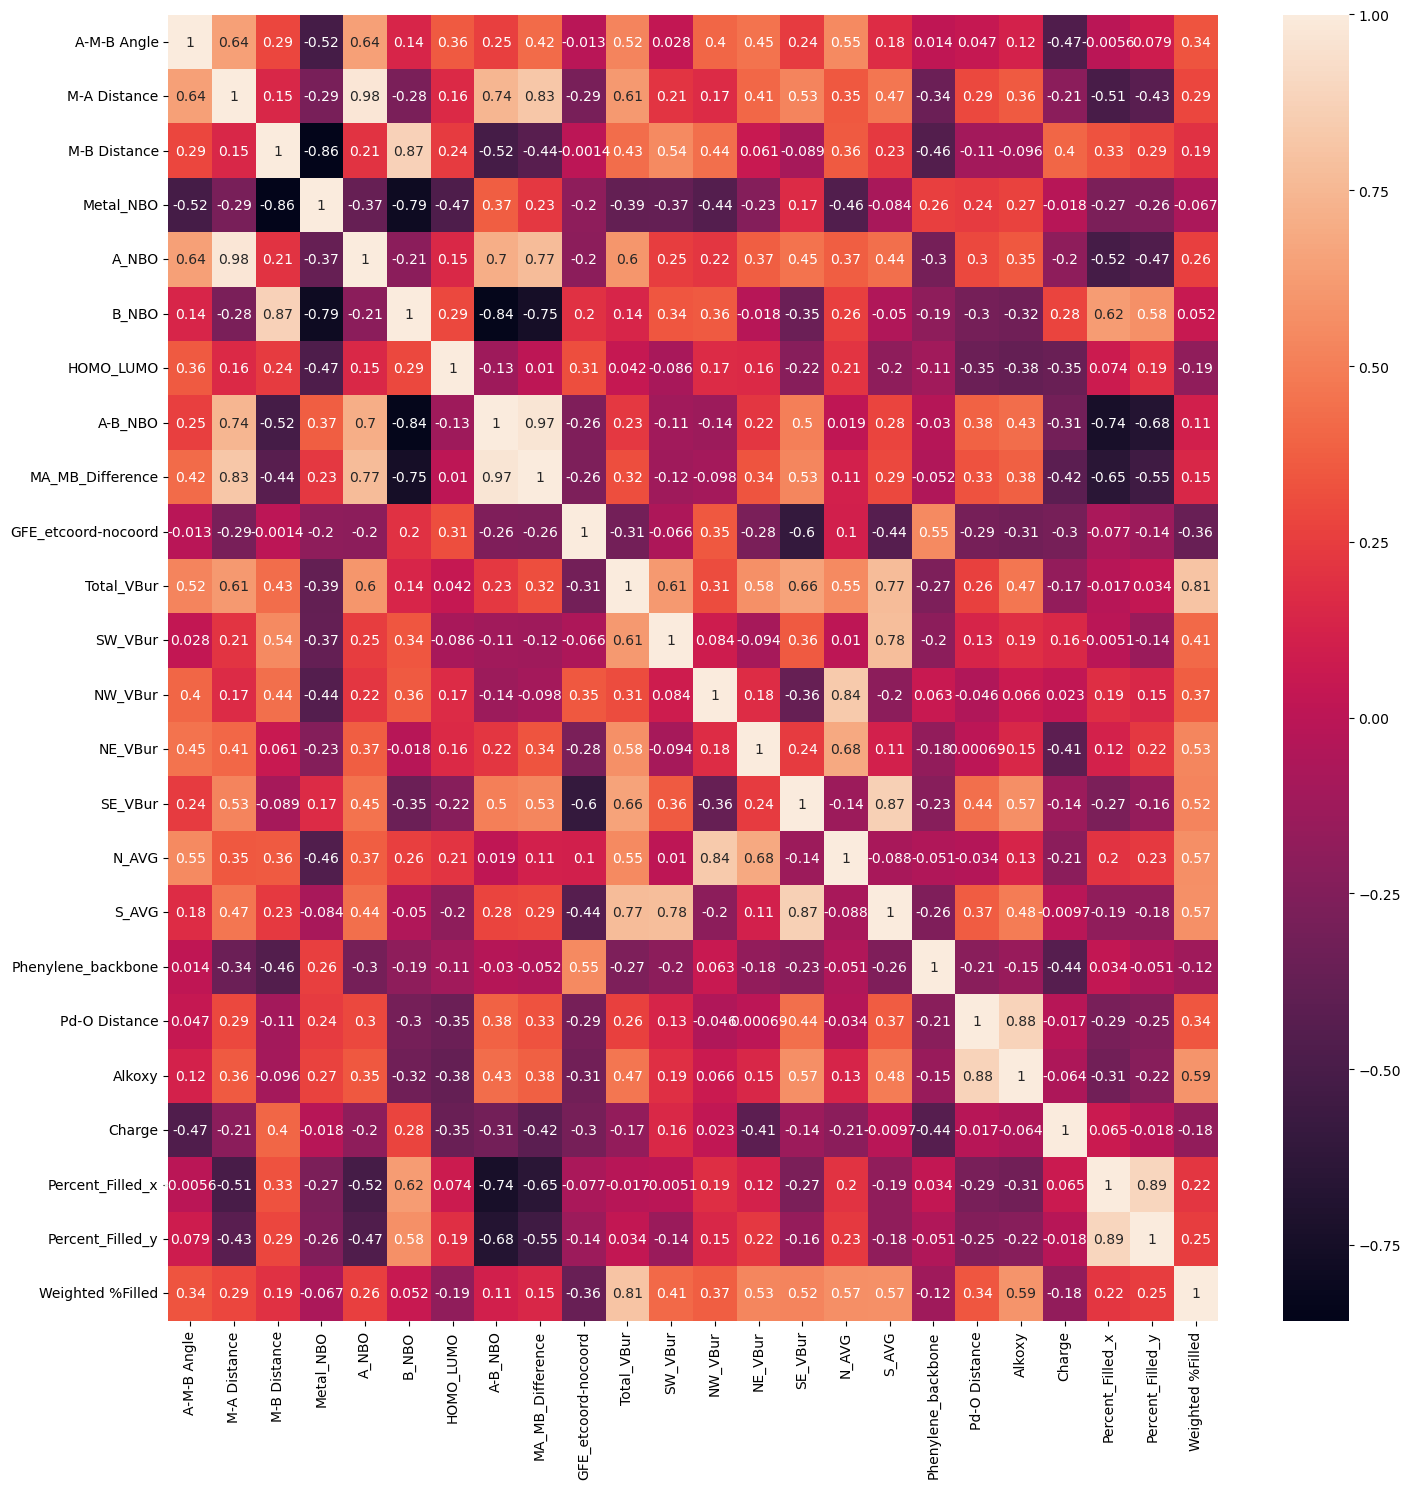

In [77]:
# Examine Collinearity between descriptors

name_df = training_dataset['Name']
x_df = training_dataset.drop(['Name'],axis=1)

corr_df = x_df.drop(['Nonalt'],axis=1)
mpl.pyplot.figure(figsize = (15,15))
sns.heatmap(corr_df.corr(),annot=True)
plt.tight_layout()
plt.savefig('descriptor_correlation_plot.png',dpi=600)

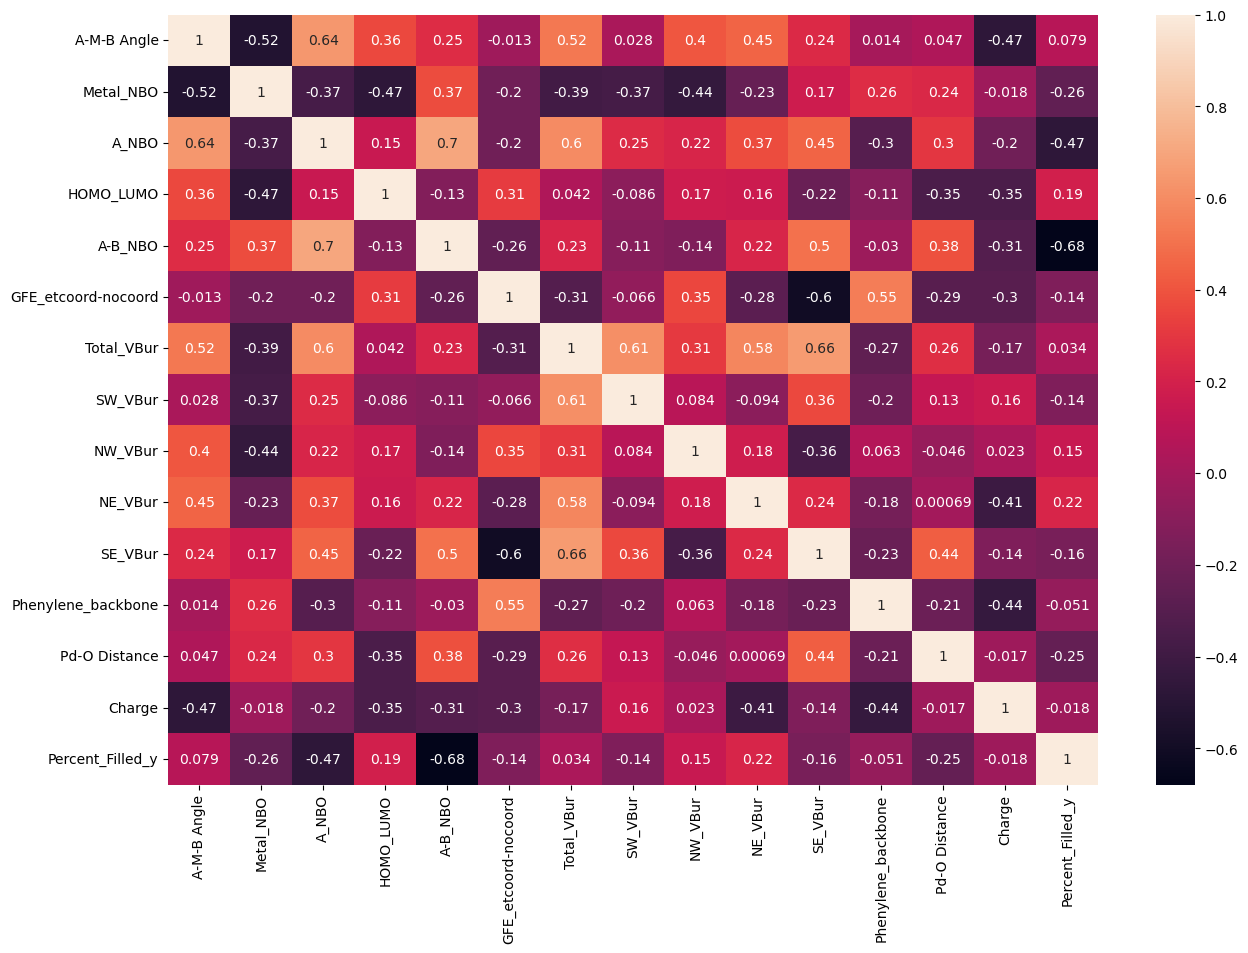

In [78]:
# Remove descriptors with high multicollinearity
x_df = x_df.drop(['M-A Distance',
                  'MA_MB_Difference',
                  'B_NBO',
                  'M-B Distance',
                  'N_AVG',
                  'S_AVG',
                  'Percent_Filled_x',
                  'Alkoxy',
                  'Weighted %Filled'],axis=1)

corr_df = x_df.drop(['Nonalt'],axis=1)
mpl.pyplot.figure(figsize = (15,10))
sns.heatmap(corr_df.corr(),annot=True)
plt.savefig('descriptor_correlation_plot_multicollinearity.png',dpi=600)
# sns_plot.savefig("descriptor_correlation_plot.png")

<Axes: >

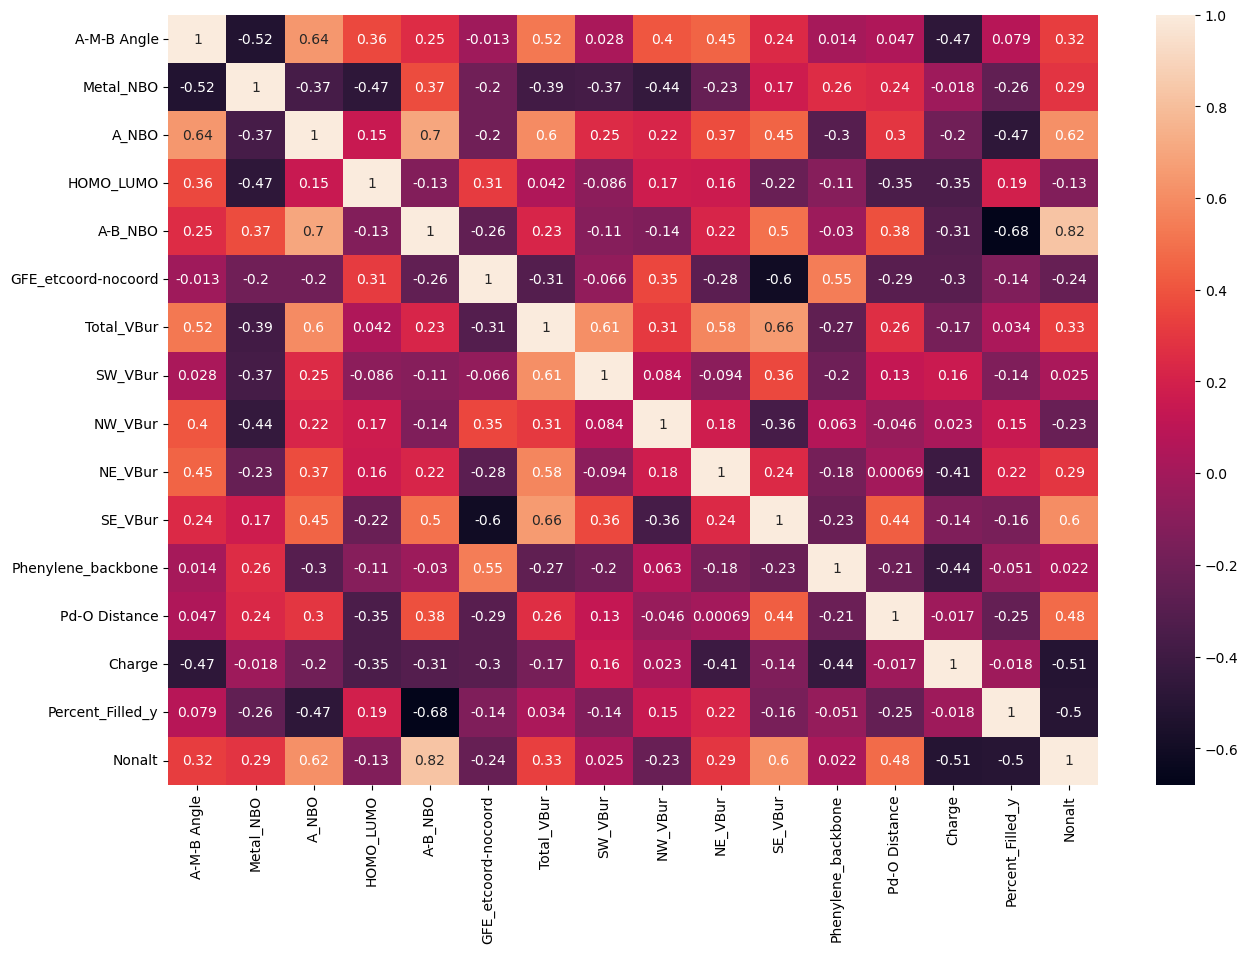

In [79]:
# Pearson coefficient correlation between descriptors and target variable (nonalt)

mpl.pyplot.figure(figsize = (15,10))
sns.heatmap(x_df.corr(),annot=True)
# plt.savefig('descriptor_correlation_plot_multicollinearity.png',dpi=600)

In [80]:
x_df

,A-M-B Angle,Metal_NBO,A_NBO,HOMO_LUMO,A-B_NBO,GFE_etcoord-nocoord,Total_VBur,SW_VBur,NW_VBur,NE_VBur,SE_VBur,Phenylene_backbone,Pd-O Distance,Charge,Percent_Filled_y,Nonalt
0,77,0.45674,-0.44516,0.13318,-0.04664,4.929471,38.7,34.2,34.7,51.9,34.2,1,0.000,1,36.549296,0.0
1,77,0.49421,-0.41997,0.13923,-0.02247,2.295188,36.2,34.4,34.1,35.3,40.8,1,4.410,1,38.661972,0.0
2,77,0.49349,-0.42170,0.15312,-0.02373,2.175061,35.8,33.9,34.7,33.6,41.2,1,0.000,1,37.253521,0.0
3,77,0.48133,-0.43169,0.14574,-0.03501,3.684693,43.6,34.4,34.0,51.9,53.9,1,0.000,1,34.859155,0.0
4,79,0.49330,-0.43370,0.16768,-0.03203,3.853403,32.9,34.3,33.9,31.8,31.7,1,0.000,1,26.760563,0.0
5,85,0.02980,1.05375,0.17512,-0.18669,11.312024,49.9,56.8,48.3,53.3,41.4,0,0.000,1,35.633803,0.0
6,90,0.04242,1.04759,0.17602,-0.17995,14.513843,51.7,49.8,54.9,52.9,49.4,0,0.000,1,45.845070,0.0
7,92,0.16457,1.00995,0.16375,-0.17217,6.288749,56.7,55.5,69.5,53.0,48.8,0,3.190,1,38.309859,0.0
8,101,0.06011,1.03053,0.15541,-0.16333,10.516887,49.4,49.5,53.4,50.2,44.6,1,0.000,1,30.563380,0.0
9,92,0.38460,1.02659,0.16132,1.95550,-2.063371,47.7,37.2,39.7,51.3,62.5,1,3.050,0,26.338028,1.0


In [81]:
# Define descriptor choices
descriptor_1 = 'A-B_NBO'
descriptor_2 = 'Charge'
descriptor_3 = 'SE_VBur'
descriptor_set = [descriptor_1,descriptor_2,descriptor_3]

x_filter_df = x_df[[descriptor_1,descriptor_2,descriptor_3,'Nonalt']] #Change descriptor name to get a different combination

N_Systems, N_Columns = x_filter_df.shape 
N_Descriptors = N_Columns - 1
array = x_filter_df.values
X_all = array[:, :N_Descriptors] 

# Scale all dataset to mean 0 stdev 1
scaler = preprocessing.StandardScaler().fit(X_all)

print('Mean:', scaler.mean_)   #Standardize virtual dataset based on the mean and std of this training dataset
print('Variance:', scaler.var_)

X_all = scaler.transform(X_all)
y_all = array[:, N_Descriptors]

# Convert back into dataframe that is standardized

Mean: [ 1.59755195  0.6097561  54.04390244]
Variance: [  0.82196742   0.2379536  150.8200238 ]


In [82]:
#Generate new descriptor dataframe
x_df_updated = pd.DataFrame(X_all, columns=[descriptor_set])
x_df_updated["Nonalt"] = x_filter_df["Nonalt"]

# Convert MultiIndex columns to single level
x_df_updated.columns = [col[0] for col in x_df_updated.columns]

# Display the DataFrame to ensure columns are correctly named
# print(x_df_updated.columns)
# print(x_df_updated.head())

# Access the 'Nonalt' column safely
nonalt_column = x_df_updated['Nonalt']
# Convert values in 'Nonalt' column to strings
x_df_updated['Nonalt'] = x_df_updated['Nonalt'].apply(lambda x: 'Non-alternating' if x == 1.0 else 'Alternating')

In [83]:
x_df_updated

,A-B_NBO,Charge,SE_VBur,Nonalt
0,-1.813532,0.80,-1.615837,Alternating
1,-1.786873,0.80,-1.078416,Alternating
2,-1.788262,0.80,-1.045845,Alternating
3,-1.800704,0.80,-0.011718,Alternating
4,-1.797417,0.80,-1.819406,Alternating
5,-1.968006,0.80,-1.029560,Alternating
6,-1.960572,0.80,-0.378141,Alternating
7,-1.951991,0.80,-0.426997,Alternating
8,-1.942240,0.80,-0.768992,Alternating
9,0.394814,-1.25,0.688558,Non-alternating


In [84]:
# Obtain virtual candidate dataset and standardize it with the mean and std calculated above

#Import descriptor dataset for virtual candidates 
# Define the relative path to your file in the parent directory
candidate_relative_path = '../../intermediates/virtual_candidates/all_descriptor_data_virtual.csv'

# Combine the parent directory with the relative path
candidate_file_path = os.path.abspath(candidate_relative_path)
candidate_dataset = pd.read_csv(candidate_file_path)
candidate_dataset = candidate_dataset.drop('Unnamed: 0',axis=1)
candidate_name = candidate_dataset['Name']
print(candidate_name)
candidate_dataset_df = candidate_dataset.drop(['Name'],axis=1)

#Obtain selected descriptors 
candidate_dataset_filter_df = candidate_dataset_df[[descriptor_1,descriptor_2,descriptor_3]]  #Change descriptor name to get a different combination
N_Systems, N_Columns = candidate_dataset_filter_df.shape 
array = candidate_dataset_filter_df.values
candidate_dataset_all = array[:, :N_Columns] 

#Standardize dataset based on mean and variance obtained from training set 
train_mean = np.tile(scaler.mean_, (candidate_dataset_all.shape[0], 1))
std_candidate_array = candidate_dataset_all-train_mean
train_variance = np.tile(scaler.var_, (candidate_dataset_all.shape[0], 1))
train_sd = np.sqrt(train_variance)
std_candidate_array =std_candidate_array / np.sqrt(train_variance)
name_index = [17,42,43,50,18]  #Index for synthesized candidates
for i in name_index:
    print(candidate_name[i], std_candidate_array[i])
std_candidate_array[name_index] #Use this for tested candidates only


0      c-n-1
1      c-n-2
2      c-n-3
3      c-o-1
4      c-o-2
       ...  
56    p-o-43
57    p-o-44
58    p-o-45
59     p-o-8
60     p-o-9
Name: Name, Length: 61, dtype: object
n-o-5 [-1.59157672 -1.25       -1.41226865]
p-o-29 [0.52166935 0.8        0.57455959]
p-o-30 [0.50214637 0.8        0.89212639]
p-o-37 [ 0.48219323  0.8        -0.18271511]
n-o-6 [-1.59847042 -1.25       -0.13385868]


array([[-1.59157672, -1.25      , -1.41226865],
       [ 0.52166935,  0.8       ,  0.57455959],
       [ 0.50214637,  0.8       ,  0.89212639],
       [ 0.48219323,  0.8       , -0.18271511],
       [-1.59847042, -1.25      , -0.13385868]])

In [85]:
# Add catalyst name back into training dataset
training_std_df = pd.merge(name_df,x_df_updated, left_index=True, right_index=True)
training_std_df

,Name,A-B_NBO,Charge,SE_VBur,Nonalt
0,n-n-1,-1.813532,0.80,-1.615837,Alternating
1,n-n-2,-1.786873,0.80,-1.078416,Alternating
2,n-n-3,-1.788262,0.80,-1.045845,Alternating
3,n-n-4,-1.800704,0.80,-0.011718,Alternating
4,n-n-5,-1.797417,0.80,-1.819406,Alternating
5,p-p-1,-1.968006,0.80,-1.029560,Alternating
6,p-p-2,-1.960572,0.80,-0.378141,Alternating
7,p-p-3,-1.951991,0.80,-0.426997,Alternating
8,p-p-4,-1.942240,0.80,-0.768992,Alternating
9,p-so-1,0.394814,-1.25,0.688558,Non-alternating


In [86]:
# Generate candidate dataframe with name and relevant descriptors
candidates_std_df = pd.DataFrame(std_candidate_array, columns=[descriptor_1, descriptor_2, descriptor_3])
candidates_std_df['Nonalt'] = 'Candidate'
candidates_std_df['Name'] = candidate_name

In [87]:
# Ensure both DataFrames have the same columns
candidates_std_df = candidates_std_df[training_std_df.columns]
#Combine traning and candidates dataset together
training_candidate_std_df = pd.concat([training_std_df,candidates_std_df],ignore_index = True)
training_candidate_std_df


# training_candidate_std_df['Nonalt'] = pd.Categorical(training_candidate_std_df['Nonalt'], 
#                                                      categories=['Non-alternating', 'Alternating', 'Candidate'], ordered=True)
# training_candidate_std_df = training_candidate_std_df.sort_values('Nonalt')

# #Identify key candidates, change 'nonalt' into target
# key_candidates = ['p-o-41', 'p-o-13', 'p-o-14', 'p-o-42','n-o-1','p-n-1']

# training_candidate_std_df['Nonalt'] = training_candidate_std_df.apply(lambda row: 'Target' if row['Name'] 
#                                                                       in key_candidates else row['Nonalt'], axis=1)
# print(training_candidate_std_df)




,Name,A-B_NBO,Charge,SE_VBur,Nonalt
0,n-n-1,-1.813532,0.8,-1.615837,Alternating
1,n-n-2,-1.786873,0.8,-1.078416,Alternating
2,n-n-3,-1.788262,0.8,-1.045845,Alternating
3,n-n-4,-1.800704,0.8,-0.011718,Alternating
4,n-n-5,-1.797417,0.8,-1.819406,Alternating
...,...,...,...,...,...
97,p-o-43,0.539317,0.8,0.704843,Candidate
98,p-o-44,0.525508,0.8,0.020853,Candidate
99,p-o-45,0.502643,0.8,0.354706,Candidate
100,p-o-8,0.498848,0.8,-0.475854,Candidate


In [88]:
# Replace 'Nonalt' into name of targets in manuscript
candidate_target_name_df = pd.DataFrame(candidates_std_df)

name_to_number = {
    'p-o-13': 1,
    'p-o-14': 2,
    'p-o-41': 3,
    'p-o-42': 4,
    'p-n-1' : 5,
    'c-o-4' : 6,
    'c-o-6' : 7,
    'c-o-7' : 8
}

target_list = ['p-o-13','p-o-14','p-o-41','p-o-42','p-n-1','c-o-4','c-o-6','c-o-7']
name_list = ['1','2','3','4','5','6','7','8']
for target, name in zip(target_list, name_list):
    subset_condition = candidate_target_name_df['Name'].isin([target])
    candidate_target_name_df.loc[subset_condition, 'Nonalt'] = name

print(candidate_target_name_df)


#Combine training and named candidates dataset together, remove candidate label
training_target_name_std_df = pd.concat([training_std_df,candidate_target_name_df],ignore_index = True)
print(training_target_name_std_df)
training_target_name_std_df['Nonalt'] = pd.Categorical(training_target_name_std_df['Nonalt'], 
                                                     categories=['Non-alternating', 'Alternating', 'Candidate','1','2','3','4','5','6','7','8'], ordered=True)

training_target_name_std_df = training_target_name_std_df.sort_values('Nonalt')
training_candidate_target_std_df = training_target_name_std_df

categories = ['Non-alternating', 'Alternating', '1', '2', '3', '4','5','6','7','8']
training_target_name_std_df = training_target_name_std_df[training_target_name_std_df['Nonalt'].isin(categories)]

      Name   A-B_NBO  Charge   SE_VBur     Nonalt
0    c-n-1 -0.537634   -1.25  0.199994  Candidate
1    c-n-2 -1.106547    0.80  0.395419  Candidate
2    c-n-3 -1.055357    0.80  0.077853  Candidate
3    c-o-1 -0.689262   -1.25  0.997982  Candidate
4    c-o-2 -0.324106    0.80  1.152694  Candidate
..     ...       ...     ...       ...        ...
56  p-o-43  0.539317    0.80  0.704843  Candidate
57  p-o-44  0.525508    0.80  0.020853  Candidate
58  p-o-45  0.502643    0.80  0.354706  Candidate
59   p-o-8  0.498848    0.80 -0.475854  Candidate
60   p-o-9  0.474219    0.80 -0.345570  Candidate

[61 rows x 5 columns]
       Name   A-B_NBO  Charge   SE_VBur       Nonalt
0     n-n-1 -1.813532     0.8 -1.615837  Alternating
1     n-n-2 -1.786873     0.8 -1.078416  Alternating
2     n-n-3 -1.788262     0.8 -1.045845  Alternating
3     n-n-4 -1.800704     0.8 -0.011718  Alternating
4     n-n-5 -1.797417     0.8 -1.819406  Alternating
..      ...       ...     ...       ...          ...
97   p

In [89]:
training_candidate_target_std_df

,Name,A-B_NBO,Charge,SE_VBur,Nonalt
34,pnpo-3,0.728712,0.80,-0.589852,Non-alternating
30,pnpo-11,0.689699,0.80,1.584259,Non-alternating
31,pnpo-12,0.688155,0.80,1.641258,Non-alternating
24,p-so-9,0.396314,-1.25,-0.329284,Non-alternating
23,p-so-8,0.388693,-1.25,1.168980,Non-alternating
...,...,...,...,...,...
96,p-o-42,0.545086,0.80,0.558274,4
60,p-n-1,-0.143524,0.80,-0.606138,5
47,c-o-4,-0.697954,-1.25,1.225979,6
49,c-o-6,-0.822537,-1.25,0.989839,7


In [90]:
# Generate dataframe that has all candidate names under 'Nonalt'
candidate_name_std_df = candidates_std_df
candidate_name_std_df['Nonalt'] = candidate_name_std_df['Name'] 
candidate_name_std_df


#Combine training and named candidates dataset together
training_candidate_name_std_df = pd.concat([training_std_df,candidate_name_std_df],ignore_index = True)
training_candidate_name_std_df = training_candidate_name_std_df.sort_values('Nonalt')
training_candidate_name_std_df 

nonalt_unique_candidate_name =  training_candidate_name_std_df['Nonalt'].unique()
print(nonalt_unique_candidate_name)

['Alternating' 'Non-alternating' 'c-n-1' 'c-n-2' 'c-n-3' 'c-o-1' 'c-o-2'
 'c-o-3' 'c-o-4' 'c-o-5' 'c-o-6' 'c-o-7' 'c-o-8' 'c-p-1' 'c-s-1' 'n-o-1'
 'n-o-2' 'n-o-3' 'n-o-4' 'n-o-5' 'n-o-6' 'p-n-1' 'p-n-2' 'p-n-3' 'p-n-4'
 'p-o-10' 'p-o-11' 'p-o-12' 'p-o-13' 'p-o-14' 'p-o-15' 'p-o-16' 'p-o-17'
 'p-o-18' 'p-o-19' 'p-o-20' 'p-o-21' 'p-o-22' 'p-o-23' 'p-o-24' 'p-o-25'
 'p-o-26' 'p-o-27' 'p-o-28' 'p-o-29' 'p-o-30' 'p-o-31' 'p-o-32' 'p-o-33'
 'p-o-34' 'p-o-35' 'p-o-36' 'p-o-37' 'p-o-38' 'p-o-39' 'p-o-40' 'p-o-41'
 'p-o-42' 'p-o-43' 'p-o-44' 'p-o-45' 'p-o-8' 'p-o-9']


In [91]:
training_candidate_target_std_df['Nonalt'].unique()

['Non-alternating', 'Alternating', 'Candidate', '1', '2', ..., '4', '5', '6', '7', '8']
Length: 11
Categories (11, object): ['Non-alternating' < 'Alternating' < 'Candidate' < '1' ... '5' < '6' < '7' < '8']

In [148]:
pio.renderers.default = 'iframe'

nonalt_unique = training_candidate_target_std_df['Nonalt'].unique()
colors = {"Non-alternating": "#0bb4ff", 
          "Alternating": "#ffa300", 
          "Candidate":"#50e991", 
          '1':'maroon', 
          '2':'black',
          '3':'blue',
          '4':'red',
          '5':'gold',
          '6':'darkgreen',
          '7':'#dc0ab4',
          '8':'sienna',
         }
markers = {
    'Non-alternating': 'circle',
    'Alternating': 'circle',
    'Candidate': 'diamond',
    '1':'square',
    '2':'square',
    '3':'square',
    '4':'square',
    '5':'square',
    '6':'square',
    '7':'square',
    '8':'square',
}
name_list = training_candidate_target_std_df["Name"]
title="All Data 3D"

for i in nonalt_unique:
    safe_i = i.replace("-", "_")  # Replace hyphens with underscores
    
    globals()[f"Data_{safe_i}"]=go.Scatter3d(
        x=training_candidate_target_std_df.loc[training_candidate_target_std_df['Nonalt'] == i ,"A-B_NBO"],
        y=training_candidate_target_std_df.loc[training_candidate_target_std_df['Nonalt'] == i ,"Charge"],
        z=training_candidate_target_std_df.loc[training_candidate_target_std_df['Nonalt'] == i ,"SE_VBur"],
        text = training_candidate_target_std_df.loc[training_candidate_target_std_df['Nonalt'] == i ,"Name"],
        name=i,
        hovertemplate='NBO_diff_standardized: %{x} <br>' + \
            'Overall_charge_standardized: %{y} <br>' + \
            '%_VBur_SE_standardized: %{z} <br>' + \
            'Name: %{text} <br> ' + \
            'Nonalt: {0}'.format(i),
        mode='markers',
        marker=dict(
            size=8,
            color=colors[i],           
            opacity=0.8,
            symbol=markers[i]
        )
    )

fig = go.Figure(data=[globals()[f"Data_{i.replace('-', '_')}"] for i in nonalt_unique])
# fig = go.Figure(data=[Data_Nonalternating, Data_Alternating,Data_Candidate,Data_1,Data_2,Data_3,Data_4])


camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.2, y=-2.0, z=1.7)
)

fig.update_layout(
scene_camera=camera,
autosize=True,
template="plotly_white",
scene={
    "xaxis": {
        "title": {
            "text": r'NBO_diff_standardized',
            "font": {
                "size": 12
            }
        },
        "tickfont": {
            "size": 12
        }
    },
    "yaxis": {
        "title": {
            "text": r'Overall_charge_standardized',
            "font": {
                "size": 12
            }
        },
        "tickfont": {
            "size": 12
        }
    },
    "zaxis": {
        "title": {
            "text": r'%_VBur_SE_standardized',
            "font": {
                "size": 12
            }
        },
        "tickfont": {
            "size": 12
        }
    }
},
width=900, height=800,
showlegend=True,
title=title,
legend=dict(
    orientation="h",
    x=0.5,
    y=0,
    xanchor='center',
    yanchor='top',
    font=dict(size=20),
    itemsizing='constant'
    ),
margin=dict(l=0, r=0, b=0, t=0)
)

    




# camera = dict(
#     up=dict(x=0, y=0, z=1),
#     center=dict(x=0, y=0, z=0),
#     eye=dict(x=-1, y=-1.75, z=1.5)
# )

# fig.update_layout(
#     scene_camera=camera,
#     autosize=True,
#     template="plotly_white",
#     scene={
#         "xaxis_title":r'NBO_diff_standardized',
#         "yaxis_title":r'Overall_charge_standardized',
#         "zaxis_title":r'%_Filled_y_standardized'
#     },
#     width=800, height=800,
#     showlegend=True,
#     title="All Data 3D"
# )
pio.write_image(fig, str(title+'.png'),scale=6, width=900, height=900)
fig.show(renderer='iframe')

## Support Vector Machine

In [93]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    training_std_df.drop(columns=["Nonalt","Name"]), 
    training_std_df['Nonalt'],
    train_size=0.6,
    random_state=123,
    shuffle=True
) 

In [94]:
SVM = make_pipeline(
    StandardScaler(),
    SVC()
)

param_grid = {
    'svc__C': [0.5 ,1, 5, 10, 50, 75, 100, 125],
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.0025, 0.005, 0.0075, 0.01]
}

grid = GridSearchCV(SVM, param_grid, n_jobs=-2, cv=LeaveOneOut())
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=-2,
             param_grid={'svc__C': [0.5, 1, 5, 10, 50, 75, 100, 125],
                         'svc__gamma': [0.0001, 0.0005, 0.001, 0.0025, 0.005,
                                        0.0075, 0.01]})

In [95]:
print(grid.best_params_)
model = grid.best_estimator_
y_hat = model.predict(Xtest)

{'svc__C': 5, 'svc__gamma': 0.005}


In [96]:
Xtest

,A-B_NBO,Charge,SE_VBur
27,0.485866,0.80,-1.021417
12,0.389321,-1.25,1.624973
11,0.392586,-1.25,1.543545
35,0.735209,0.80,0.476847
10,0.387237,-1.25,1.006125
5,-1.968006,0.80,-1.029560
1,-1.786873,0.80,-1.078416
6,-1.960572,0.80,-0.378141
39,0.693472,0.80,0.729272
26,0.485414,0.80,-1.086559


In [97]:
print(classification_report(ytest, y_hat))

                 precision    recall  f1-score   support

    Alternating       1.00      0.67      0.80         6
Non-alternating       0.85      1.00      0.92        11

       accuracy                           0.88        17
      macro avg       0.92      0.83      0.86        17
   weighted avg       0.90      0.88      0.88        17



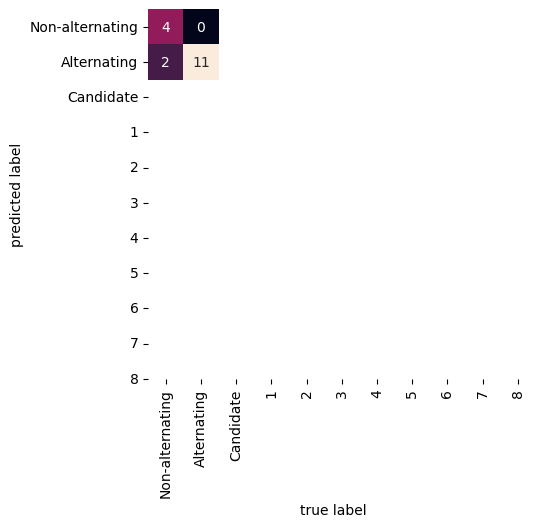

In [98]:
confMat(ytest, y_hat)

In [99]:
VisualizeBoundaryTargetNames(GenerateMesh(training_target_name_std_df, model, descriptor_set, dimValue = None), title="SVM Decision Boundary 3D")

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



## Predict Candidates

In [100]:
descriptor_candidates_df = candidates_std_df.drop(['Nonalt','Name'],axis=1)
#candidate_name
candidate_prediction = model.predict(descriptor_candidates_df)

candidate_prediction_df = descriptor_candidates_df
candidate_prediction_df['Prediction'] = candidate_prediction
candidate_prediction_df['Name'] = candidate_name

print(candidate_prediction_df)

# Save the DataFrame to a csv file
output_file_path = 'svm_candidate_prediction.csv'  # Specify the desired file name and path
candidate_prediction_df.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")


     A-B_NBO  Charge   SE_VBur       Prediction    Name
0  -0.537634   -1.25  0.199994  Non-alternating   c-n-1
1  -1.106547    0.80  0.395419      Alternating   c-n-2
2  -1.055357    0.80  0.077853      Alternating   c-n-3
3  -0.689262   -1.25  0.997982  Non-alternating   c-o-1
4  -0.324106    0.80  1.152694  Non-alternating   c-o-2
..       ...     ...       ...              ...     ...
56  0.539317    0.80  0.704843  Non-alternating  p-o-43
57  0.525508    0.80  0.020853  Non-alternating  p-o-44
58  0.502643    0.80  0.354706  Non-alternating  p-o-45
59  0.498848    0.80 -0.475854  Non-alternating   p-o-8
60  0.474219    0.80 -0.345570  Non-alternating   p-o-9

[61 rows x 5 columns]
DataFrame saved to svm_candidate_prediction.csv


## Naive Bayes

In [101]:
NBC = GaussianNB()

param_grid = {
    'var_smoothing': [0.1,0.01,0.001,0.0001,0.00001,0.000001],
}

grid = GridSearchCV(NBC, param_grid, n_jobs=-1, cv=LeaveOneOut())
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=LeaveOneOut(), estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [0.1, 0.01, 0.001, 0.0001, 1e-05,
                                           1e-06]})

In [102]:
print(grid.best_params_)
model = grid.best_estimator_
y_hat = model.predict(Xtest)

{'var_smoothing': 0.1}


In [103]:
print(classification_report(ytest, y_hat))

                 precision    recall  f1-score   support

    Alternating       1.00      0.67      0.80         6
Non-alternating       0.85      1.00      0.92        11

       accuracy                           0.88        17
      macro avg       0.92      0.83      0.86        17
   weighted avg       0.90      0.88      0.88        17



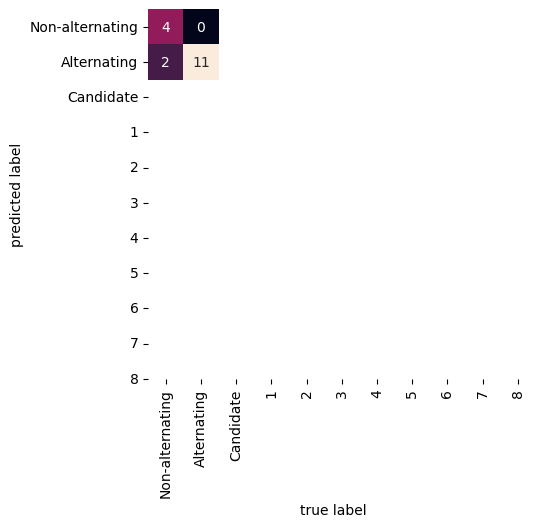

In [104]:
confMat(ytest, y_hat)

In [105]:
# vizBoundIRIS(IRISMesh(iris, model, dimValue = None), title="Naive Bayes Decision Boundary 3D")

VisualizeBoundaryTargetNames(GenerateMesh(training_target_name_std_df, model, descriptor_set, dimValue = None), title="Naive Bayes Decision Boundary 3D")

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but GaussianNB was fitted with feature names



In [106]:
descriptor_candidates_df = candidates_std_df.drop(['Nonalt','Name'],axis=1)
#candidate_name
candidate_prediction = model.predict(descriptor_candidates_df)

candidate_prediction_df = descriptor_candidates_df
candidate_prediction_df['Prediction'] = candidate_prediction
candidate_prediction_df['Name'] = candidate_name

print(candidate_prediction_df)
# Save the DataFrame to a csv file
output_file_path = 'naive_bayes_candidate_prediction.csv'  # Specify the desired file name and path
candidate_prediction_df.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")


     A-B_NBO  Charge   SE_VBur       Prediction    Name
0  -0.537634   -1.25  0.199994  Non-alternating   c-n-1
1  -1.106547    0.80  0.395419      Alternating   c-n-2
2  -1.055357    0.80  0.077853      Alternating   c-n-3
3  -0.689262   -1.25  0.997982  Non-alternating   c-o-1
4  -0.324106    0.80  1.152694  Non-alternating   c-o-2
..       ...     ...       ...              ...     ...
56  0.539317    0.80  0.704843  Non-alternating  p-o-43
57  0.525508    0.80  0.020853  Non-alternating  p-o-44
58  0.502643    0.80  0.354706  Non-alternating  p-o-45
59  0.498848    0.80 -0.475854  Non-alternating   p-o-8
60  0.474219    0.80 -0.345570  Non-alternating   p-o-9

[61 rows x 5 columns]
DataFrame saved to naive_bayes_candidate_prediction.csv


## Random Forest

In [107]:
RF = RandomForestClassifier(random_state = 123)

param_grid = {
    'n_estimators': [10, 25],
    'min_samples_leaf': [1,2,3],
    'max_samples': [0.6, 0.7, 0.8, 0.9, 1],
    'max_features': [2,3,4]
}

grid = GridSearchCV(RF, param_grid, n_jobs=-2, cv=LeaveOneOut())
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=LeaveOneOut(),
             estimator=RandomForestClassifier(random_state=123), n_jobs=-2,
             param_grid={'max_features': [2, 3, 4],
                         'max_samples': [0.6, 0.7, 0.8, 0.9, 1],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [10, 25]})

In [108]:
print(grid.best_params_)
model = grid.best_estimator_
y_hat = model.predict(Xtest)

{'max_features': 2, 'max_samples': 0.6, 'min_samples_leaf': 1, 'n_estimators': 10}


In [109]:
print(classification_report(ytest, y_hat))

                 precision    recall  f1-score   support

    Alternating       0.86      1.00      0.92         6
Non-alternating       1.00      0.91      0.95        11

       accuracy                           0.94        17
      macro avg       0.93      0.95      0.94        17
   weighted avg       0.95      0.94      0.94        17



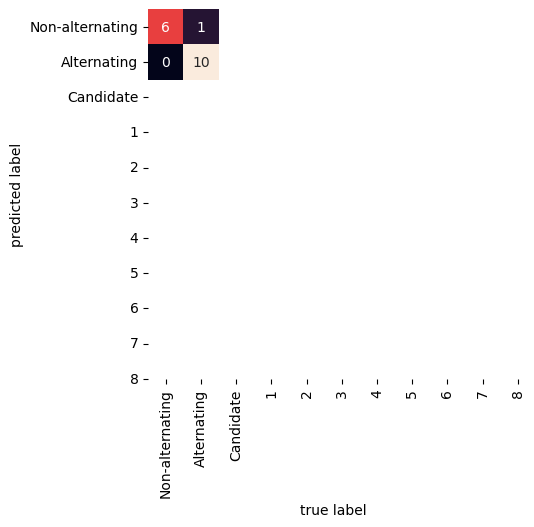

In [110]:
confMat(ytest, y_hat)

In [111]:
# vizBoundIRIS(IRISMesh(iris, model, dimValue = None), title="Naive Bayes Decision Boundary 3D")

VisualizeBoundaryTargetNames(GenerateMesh(training_target_name_std_df, model, descriptor_set, dimValue = None), title="Random Forest Decision Boundary 3D")

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [112]:
descriptor_candidates_df = candidates_std_df.drop(['Nonalt','Name'],axis=1)
#candidate_name
candidate_prediction = model.predict(descriptor_candidates_df)

candidate_prediction_df = descriptor_candidates_df
candidate_prediction_df['Prediction'] = candidate_prediction
candidate_prediction_df['Name'] = candidate_name

print(candidate_prediction_df)
# Save the DataFrame to a csv file
output_file_path = 'random_forest_candidate_prediction.csv'  # Specify the desired file name and path
candidate_prediction_df.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

     A-B_NBO  Charge   SE_VBur       Prediction    Name
0  -0.537634   -1.25  0.199994  Non-alternating   c-n-1
1  -1.106547    0.80  0.395419      Alternating   c-n-2
2  -1.055357    0.80  0.077853      Alternating   c-n-3
3  -0.689262   -1.25  0.997982  Non-alternating   c-o-1
4  -0.324106    0.80  1.152694  Non-alternating   c-o-2
..       ...     ...       ...              ...     ...
56  0.539317    0.80  0.704843  Non-alternating  p-o-43
57  0.525508    0.80  0.020853  Non-alternating  p-o-44
58  0.502643    0.80  0.354706  Non-alternating  p-o-45
59  0.498848    0.80 -0.475854  Non-alternating   p-o-8
60  0.474219    0.80 -0.345570  Non-alternating   p-o-9

[61 rows x 5 columns]
DataFrame saved to random_forest_candidate_prediction.csv


## Gradient Boosting

In [113]:
GBM = GradientBoostingClassifier(random_state=123)

param_grid = {
    'n_estimators': [10, 20, 30],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8],
    'min_samples_leaf': [1,2,3],
    'max_features': [2,3,4],
    'max_depth': [2,3,4]
}

grid = GridSearchCV(GBM, param_grid, n_jobs=-1, cv=LeaveOneOut())
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=LeaveOneOut(),
             estimator=GradientBoostingClassifier(random_state=123), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [2, 3, 4],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [10, 20, 30],
                         'subsample': [0.6, 0.7, 0.8]})

In [114]:
print(grid.best_params_)
model = grid.best_estimator_
y_hat = model.predict(Xtest)

{'learning_rate': 0.1, 'max_depth': 2, 'max_features': 3, 'min_samples_leaf': 2, 'n_estimators': 10, 'subsample': 0.7}


In [115]:
print(classification_report(ytest, y_hat))

                 precision    recall  f1-score   support

    Alternating       1.00      0.67      0.80         6
Non-alternating       0.85      1.00      0.92        11

       accuracy                           0.88        17
      macro avg       0.92      0.83      0.86        17
   weighted avg       0.90      0.88      0.88        17



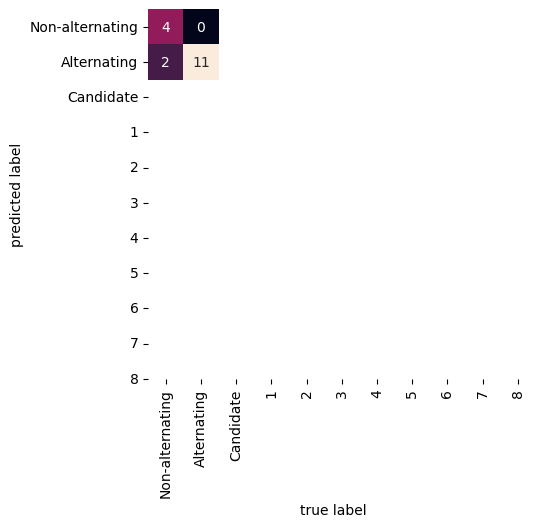

In [116]:
confMat(ytest, y_hat)

In [117]:
VisualizeBoundaryTargetNames(GenerateMesh(training_target_name_std_df, model, descriptor_set, dimValue = None), title="Gradient Boosting Decision Boundary 3D")

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names



In [118]:
descriptor_candidates_df = candidates_std_df.drop(['Nonalt','Name'],axis=1)
#candidate_name
candidate_prediction = model.predict(descriptor_candidates_df)

candidate_prediction_df = descriptor_candidates_df
candidate_prediction_df['Prediction'] = candidate_prediction
candidate_prediction_df['Name'] = candidate_name

print(candidate_prediction_df)
# Save the DataFrame to a csv file
output_file_path = 'gradient_boosting_candidate_prediction.csv'  # Specify the desired file name and path
candidate_prediction_df.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

     A-B_NBO  Charge   SE_VBur       Prediction    Name
0  -0.537634   -1.25  0.199994  Non-alternating   c-n-1
1  -1.106547    0.80  0.395419      Alternating   c-n-2
2  -1.055357    0.80  0.077853      Alternating   c-n-3
3  -0.689262   -1.25  0.997982  Non-alternating   c-o-1
4  -0.324106    0.80  1.152694  Non-alternating   c-o-2
..       ...     ...       ...              ...     ...
56  0.539317    0.80  0.704843  Non-alternating  p-o-43
57  0.525508    0.80  0.020853  Non-alternating  p-o-44
58  0.502643    0.80  0.354706  Non-alternating  p-o-45
59  0.498848    0.80 -0.475854  Non-alternating   p-o-8
60  0.474219    0.80 -0.345570  Non-alternating   p-o-9

[61 rows x 5 columns]
DataFrame saved to gradient_boosting_candidate_prediction.csv


## KNN

In [139]:
KNN = KNeighborsClassifier()

param_grid = {
    "metric": ["euclidean", "cityblock"],
    'n_neighbors': (2, 20),
}

grid = GridSearchCV(KNN, param_grid, n_jobs=-1, cv=LeaveOneOut())
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'cityblock'],
                         'n_neighbors': (2, 20)})

In [140]:
print(grid.best_params_)
model = grid.best_estimator_
y_hat = model.predict(Xtest)

{'metric': 'euclidean', 'n_neighbors': 2}


In [141]:
print(classification_report(ytest, y_hat))

                 precision    recall  f1-score   support

    Alternating       1.00      1.00      1.00         6
Non-alternating       1.00      1.00      1.00        11

       accuracy                           1.00        17
      macro avg       1.00      1.00      1.00        17
   weighted avg       1.00      1.00      1.00        17



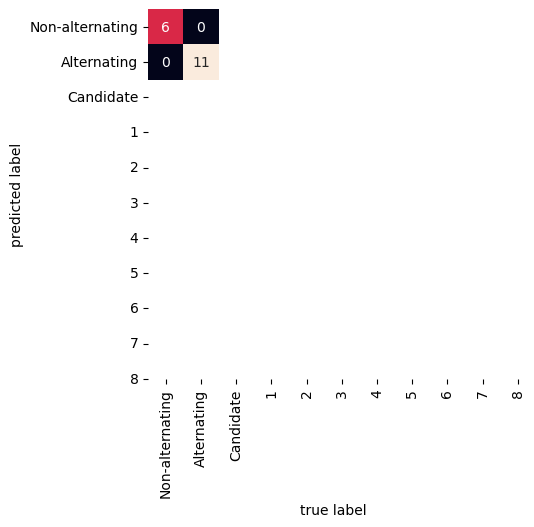

In [142]:
confMat(ytest, y_hat)

In [143]:
VisualizeBoundaryTargetNames(GenerateMesh(training_target_name_std_df, model, descriptor_set, dimValue = None), title="KNN Decision Boundary 3D")

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



In [144]:
descriptor_candidates_df = candidates_std_df.drop(['Nonalt','Name'],axis=1)
#candidate_name
candidate_prediction = model.predict(descriptor_candidates_df)

candidate_prediction_df = descriptor_candidates_df
candidate_prediction_df['Prediction'] = candidate_prediction
candidate_prediction_df['Name'] = candidate_name

print(candidate_prediction_df)
# Save the DataFrame to a csv file
output_file_path = 'knn_candidate_prediction.csv'  # Specify the desired file name and path
candidate_prediction_df.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

     A-B_NBO  Charge   SE_VBur       Prediction    Name
0  -0.537634   -1.25  0.199994  Non-alternating   c-n-1
1  -1.106547    0.80  0.395419      Alternating   c-n-2
2  -1.055357    0.80  0.077853      Alternating   c-n-3
3  -0.689262   -1.25  0.997982  Non-alternating   c-o-1
4  -0.324106    0.80  1.152694  Non-alternating   c-o-2
..       ...     ...       ...              ...     ...
56  0.539317    0.80  0.704843  Non-alternating  p-o-43
57  0.525508    0.80  0.020853  Non-alternating  p-o-44
58  0.502643    0.80  0.354706  Non-alternating  p-o-45
59  0.498848    0.80 -0.475854  Non-alternating   p-o-8
60  0.474219    0.80 -0.345570  Non-alternating   p-o-9

[61 rows x 5 columns]
DataFrame saved to knn_candidate_prediction.csv


## Decision Trees

In [125]:
DT = DecisionTreeClassifier()

param_grid = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth': list(range(1,11)),
    'min_samples_split' : list(range(2,11)),
    'max_leaf_nodes': list(range(2,11))
}

grid = GridSearchCV(DT, param_grid, n_jobs=-1, cv=LeaveOneOut())
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=LeaveOneOut(), estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'splitter': ['best', 'random']})

{'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 4, 'min_samples_split': 6, 'splitter': 'random'}
                 precision    recall  f1-score   support

    Alternating       0.86      1.00      0.92         6
Non-alternating       1.00      0.91      0.95        11

       accuracy                           0.94        17
      macro avg       0.93      0.95      0.94        17
   weighted avg       0.95      0.94      0.94        17



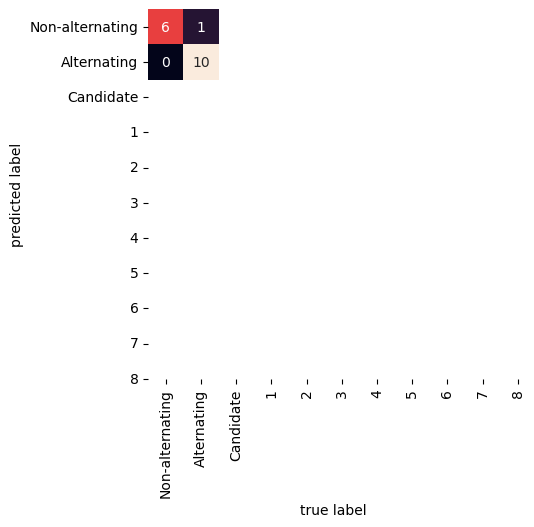

In [126]:
print(grid.best_params_)
model = grid.best_estimator_
y_hat = model.predict(Xtest)
print(classification_report(ytest, y_hat))
confMat(ytest, y_hat)

In [127]:
VisualizeBoundaryTargetNames(GenerateMesh(training_target_name_std_df, model, descriptor_set, dimValue = None), title="DT Decision Boundary 3D")

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [128]:
descriptor_candidates_df = candidates_std_df.drop(['Nonalt','Name'],axis=1)
#candidate_name
candidate_prediction = model.predict(descriptor_candidates_df)

candidate_prediction_df = descriptor_candidates_df
candidate_prediction_df['Prediction'] = candidate_prediction
candidate_prediction_df['Name'] = candidate_name

print(candidate_prediction_df)
# Save the DataFrame to a csv file
output_file_path = 'decision_tree_candidate_prediction.csv'  # Specify the desired file name and path
candidate_prediction_df.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

     A-B_NBO  Charge   SE_VBur       Prediction    Name
0  -0.537634   -1.25  0.199994      Alternating   c-n-1
1  -1.106547    0.80  0.395419      Alternating   c-n-2
2  -1.055357    0.80  0.077853      Alternating   c-n-3
3  -0.689262   -1.25  0.997982      Alternating   c-o-1
4  -0.324106    0.80  1.152694      Alternating   c-o-2
..       ...     ...       ...              ...     ...
56  0.539317    0.80  0.704843  Non-alternating  p-o-43
57  0.525508    0.80  0.020853  Non-alternating  p-o-44
58  0.502643    0.80  0.354706  Non-alternating  p-o-45
59  0.498848    0.80 -0.475854  Non-alternating   p-o-8
60  0.474219    0.80 -0.345570  Non-alternating   p-o-9

[61 rows x 5 columns]
DataFrame saved to decision_tree_candidate_prediction.csv


## Generate figure with highlighted candidate names

In [129]:
training_std_df

,Name,A-B_NBO,Charge,SE_VBur,Nonalt
0,n-n-1,-1.813532,0.80,-1.615837,Alternating
1,n-n-2,-1.786873,0.80,-1.078416,Alternating
2,n-n-3,-1.788262,0.80,-1.045845,Alternating
3,n-n-4,-1.800704,0.80,-0.011718,Alternating
4,n-n-5,-1.797417,0.80,-1.819406,Alternating
5,p-p-1,-1.968006,0.80,-1.029560,Alternating
6,p-p-2,-1.960572,0.80,-0.378141,Alternating
7,p-p-3,-1.951991,0.80,-0.426997,Alternating
8,p-p-4,-1.942240,0.80,-0.768992,Alternating
9,p-so-1,0.394814,-1.25,0.688558,Non-alternating


In [130]:
# Sample DataFrame
candidate_target_name_df = pd.DataFrame(candidates_std_df)

name_to_number = {
    'p-o-13': 1,
    'p-o-14': 2,
    'p-o-41': 3,
    'p-o-42': 4
}

target_list = ['p-o-13','p-o-14','p-o-41','p-o-42']
name_list = ['1','2','3','4']
for target, name in zip(target_list, name_list):
    subset_condition = candidate_target_name_df['Name'].isin([target])
    candidate_target_name_df.loc[subset_condition, 'Nonalt'] = name

candidate_target_name_df

,Name,A-B_NBO,Charge,SE_VBur,Nonalt
0,c-n-1,-0.537634,-1.25,0.199994,c-n-1
1,c-n-2,-1.106547,0.80,0.395419,c-n-2
2,c-n-3,-1.055357,0.80,0.077853,c-n-3
3,c-o-1,-0.689262,-1.25,0.997982,c-o-1
4,c-o-2,-0.324106,0.80,1.152694,c-o-2
...,...,...,...,...,...
56,p-o-43,0.539317,0.80,0.704843,p-o-43
57,p-o-44,0.525508,0.80,0.020853,p-o-44
58,p-o-45,0.502643,0.80,0.354706,p-o-45
59,p-o-8,0.498848,0.80,-0.475854,p-o-8


In [131]:
#Combine traning and named candidates dataset together, remove candidate label
training_candidate_name_std_df = pd.concat([training_std_df,candidates_std_df],ignore_index = True)
training_candidate_name_std_df['Nonalt'] = pd.Categorical(training_candidate_name_std_df['Nonalt'], 
                                                     categories=['Nonalternating', 'Alternating', 'Candidate','1','2','3','4'], ordered=True)
training_candidate_name_std_df = training_candidate_name_std_df.sort_values('Nonalt')
training_candidate_name_std_df = training_candidate_name_std_df[training_candidate_name_std_df['Nonalt'] != 'Candidate']

In [132]:
training_candidate_name_std_df

,Name,A-B_NBO,Charge,SE_VBur,Nonalt
0,n-n-1,-1.813532,0.8,-1.615837,Alternating
1,n-n-2,-1.786873,0.8,-1.078416,Alternating
2,n-n-3,-1.788262,0.8,-1.045845,Alternating
3,n-n-4,-1.800704,0.8,-0.011718,Alternating
4,n-n-5,-1.797417,0.8,-1.819406,Alternating
...,...,...,...,...,...
97,p-o-43,0.539317,0.8,0.704843,NaN
98,p-o-44,0.525508,0.8,0.020853,NaN
99,p-o-45,0.502643,0.8,0.354706,NaN
100,p-o-8,0.498848,0.8,-0.475854,NaN


## Apply KNN 

In [133]:
KNN = KNeighborsClassifier()

param_grid = {
    "metric": ["euclidean", "cityblock"],
    'n_neighbors': (2, 20),
}

grid = GridSearchCV(KNN, param_grid, n_jobs=-1, cv=LeaveOneOut())
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'cityblock'],
                         'n_neighbors': (2, 20)})

In [134]:
print(grid.best_params_)
model = grid.best_estimator_
y_hat = model.predict(Xtest)

{'metric': 'euclidean', 'n_neighbors': 2}


In [135]:
print(classification_report(ytest, y_hat))

                 precision    recall  f1-score   support

    Alternating       1.00      1.00      1.00         6
Non-alternating       1.00      1.00      1.00        11

       accuracy                           1.00        17
      macro avg       1.00      1.00      1.00        17
   weighted avg       1.00      1.00      1.00        17



In [136]:
VisualizeBoundaryTargetNames(GenerateMesh(training_candidate_target_std_df, model, descriptor_set, dimValue = None), title="KNN Decision Boundary 3D")

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



{'metric': 'euclidean', 'n_neighbors': 2}
                 precision    recall  f1-score   support

    Alternating       1.00      1.00      1.00         6
Non-alternating       1.00      1.00      1.00        11

       accuracy                           1.00        17
      macro avg       1.00      1.00      1.00        17
   weighted avg       1.00      1.00      1.00        17



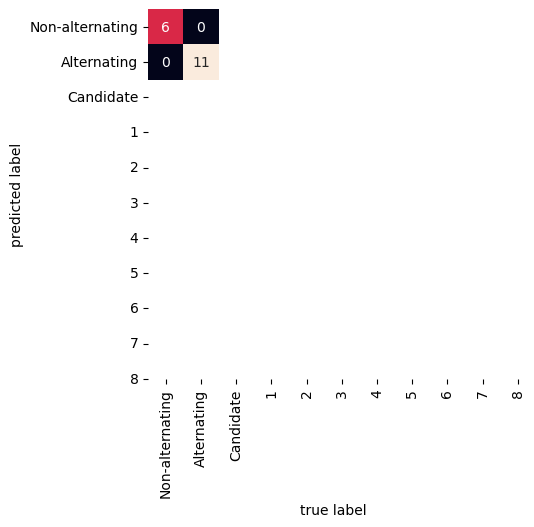

In [137]:
print(grid.best_params_)
model = grid.best_estimator_
y_hat = model.predict(Xtest)
print(classification_report(ytest, y_hat))
confMat(ytest, y_hat)

In [138]:
import plotly.graph_objects as go
import pandas as pd

# Read data from a csv
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')

fig = go.Figure(data=go.Surface(z=z_data, showscale=False))
fig.update_layout(
    title='Mt Bruno Elevation',
    width=400, height=400,
    margin=dict(t=40, r=0, l=20, b=20)
)

name = 'default'
# Default parameters which are used when `layout.scene.camera` is not provided
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.50, y=1.50, z=1.50)
)

fig.update_layout(scene_camera=camera, title=name)
fig.show()